In [1]:
import matplotlib.pyplot as plt
from circuits_benchmark.utils.get_cases import get_cases
from circuits_benchmark.transformers.hooked_tracr_transformer import HookedTracrTransformer
from circuits_benchmark.utils.iit.wandb_loader import load_model_from_wandb
from circuits_benchmark.utils.ll_model_loader.ll_model_loader_factory import get_ll_model_loader
import torch

case = 3
case = get_cases(indices=[str(case)])[0]

load_from_wandb = False
same_size = not load_from_wandb

tracr_model = get_ll_model_loader(
    case=case,
    tracr=True,
).load_ll_model_and_correspondence(device="cpu", same_size=False, output_dir="../results" if not load_from_wandb else None)[1]
ll_model_100 = get_ll_model_loader(
    case=case,
    natural=True, load_from_wandb=load_from_wandb
).load_ll_model_and_correspondence(device="cpu", same_size=False, output_dir="../results" if not load_from_wandb else None)[1]
ll_model_510 = get_ll_model_loader(
    case=case,
    siit_weights="510", load_from_wandb=load_from_wandb
).load_ll_model_and_correspondence(device="cpu", same_size=False, output_dir="../results" if not load_from_wandb else None)[1]
ll_model_110 = get_ll_model_loader(
    case=case,
    siit_weights="110", load_from_wandb=load_from_wandb
).load_ll_model_and_correspondence(device="cpu", same_size=False, output_dir="../results" if not load_from_wandb else None)[1]

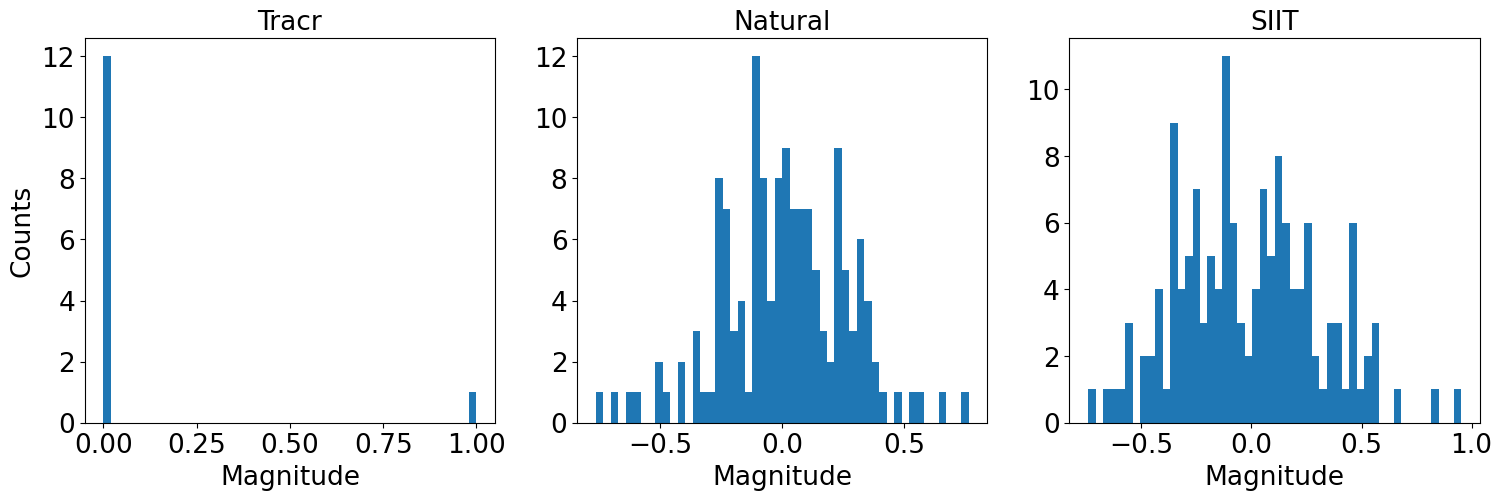

In [2]:
plt.rcParams.update({'font.size': 19})
plt.rcParams.update({'axes.labelsize': 19})
plt.rcParams.update({'axes.titlesize': 19})
plt.rcParams.update({'xtick.labelsize': 19})
plt.rcParams.update({'ytick.labelsize': 19})
def plot_attention_head(tracr_model, ll_model_100, ll_model_510, ll_model_110=None):
    fig, axs = plt.subplots(1, 4, figsize=(18, 5)) if ll_model_110 is not None else plt.subplots(1, 3, figsize=(18, 5))
    labels = ["Tracr", "Natural", "SIIT", "IIT"] if ll_model_110 is not None else ["Tracr", "Natural", "SIIT"]
    model_list = [tracr_model, ll_model_100, ll_model_510, ll_model_110] if ll_model_110 is not None else [tracr_model, ll_model_100, ll_model_510]
    for i, model in enumerate(model_list):
        # all_param_list = list(model.parameters())
        # # flatten all parameters
        # all_param_list = [p.flatten() for p in all_param_list]
        # all_param_list = torch.cat(all_param_list).detach().numpy()


        # all_param_list = model.blocks[0].attn.W_Q.flatten().detach().numpy()
        all_param_list = model.blocks[0].mlp.W_out.flatten().detach().numpy()


        # plot histogram
        axs[i].hist(all_param_list, bins=50)
        axs[i].set_title(labels[i])
        # set color of histogram
        axs[i].set_facecolor('white')

        # label all y axis as counts
        axs[0].set_ylabel("Counts")
        # label all x axis as values
        axs[i].set_xlabel("Magnitude")
    plt.savefig("plots/weight_plot_with_iit.pdf", format="pdf", bbox_inches='tight') if ll_model_110 is not None else plt.savefig("plots/weight_plot.pdf", format="pdf", bbox_inches='tight')
    plt.show()

plot_attention_head(tracr_model, ll_model_100, ll_model_510)

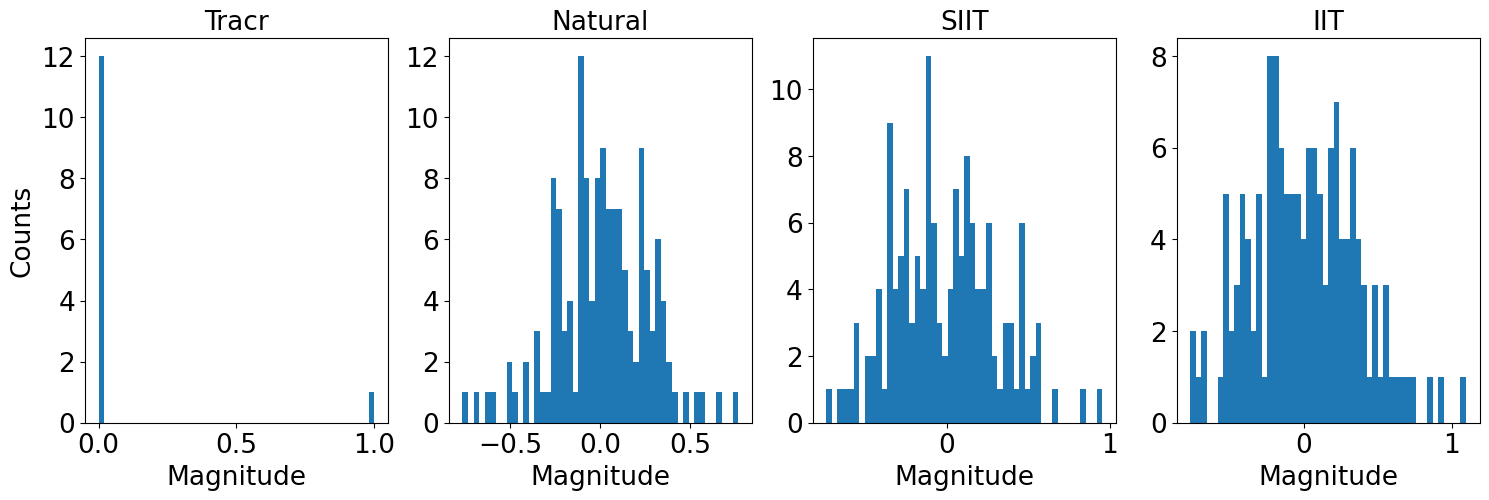

In [3]:
plot_attention_head(tracr_model, ll_model_100, ll_model_510, ll_model_110)

In [4]:

# update the model
ll_model_100.load_state_dict(ll_model_100.center_writing_weights(ll_model_100.state_dict()))
ll_model_510.load_state_dict(ll_model_510.center_writing_weights(ll_model_510.state_dict()))
ll_model_110.load_state_dict(ll_model_110.center_writing_weights(ll_model_110.state_dict()))
tracr_model.load_state_dict(tracr_model.center_writing_weights(tracr_model.state_dict()))

<All keys matched successfully>

In [5]:
# compare the average kl divergence betweem histograms of model weights
import numpy as np
def kl_divergence(model1, model2, weight_getter: callable = lambda x: x.blocks[0].mlp.W_out.flatten().detach().numpy()):
    all_param_list1 = weight_getter(model1)
    all_param_list2 = weight_getter(model2)
    # plot histogram
    hist1, _ = np.histogram(all_param_list1, bins=50)
    hist2, _ = np.histogram(all_param_list2, bins=50)
    hist1 = hist1 / np.sum(hist1)
    hist2 = hist2 / np.sum(hist2)
    # smooth the histogram
    hist1 = hist1 + 1e-6
    hist2 = hist2 + 1e-6
    return np.sum(hist1 * np.log(hist1 / hist2))


models = [ll_model_100, tracr_model, ll_model_510, ll_model_110]
confusion_matrix = np.zeros((len(models), len(models)))
for i in range(len(models)):
    for j in range(len(models)):
        confusion_matrix[i, j] = kl_divergence(models[i], models[j])

import pandas as pd

df = pd.DataFrame(confusion_matrix, columns=["Natural", "Tracr", "SIIT", "IIT"], index=["Natural", "Tracr", "SIIT", "IIT"]).round(2)
# make top triangle of confusion matrix 0
df = df.where(np.tril(np.ones(df.shape)).astype(bool))
print(df)

         Natural  Tracr  SIIT  IIT
Natural     0.00    NaN   NaN  NaN
Tracr       4.06   0.00   NaN  NaN
SIIT        1.15  10.07  0.00  NaN
IIT         0.63  10.13  0.78  0.0


In [6]:
def weight_getter(x):
    params_list = list(x.parameters())
    # flatten all parameters
    params_list = [p.flatten() for p in params_list]
    return torch.cat(params_list).detach().numpy()

confusion_matrix = np.zeros((len(models), len(models)))
for m1 in models:
    for m2 in models:
        confusion_matrix[models.index(m1), models.index(m2)] = kl_divergence(m1, m2, weight_getter=weight_getter)

import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(
        z=confusion_matrix,
        x=["Natural", "Tracr", "SIIT", "IIT"],
        y=["Natural", "Tracr", "SIIT", "IIT"],
        hoverongaps=False))
fig.update_layout(
    title="KL Divergence between model weights",
    xaxis_title="Model",
    yaxis_title="Model",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)
# add separation line between cells of confusion matrix
for x in range(len(models)):
    fig.add_shape(
        type="line",
        x0=x - 0.5,
        y0=-0.5,
        x1=x - 0.5,
        y1=len(models) - 0.5,
        line=dict(
            color="white",
            width=1
        )
    )
    fig.add_shape(
        type="line",
        x0=-0.5,
        y0=x - 0.5,
        x1=len(models) - 0.5,
        y1=x - 0.5,
        line=dict(
            color="white",
            width=1
        )
    )
fig.show()

In [7]:
df = pd.DataFrame(confusion_matrix, columns=["Natural", "Tracr", "SIIT", "IIT"], index=["Natural", "Tracr", "SIIT", "IIT"]).round(2)
# make top triangle of confusion matrix 0
df = df.where(np.tril(np.ones(df.shape)).astype(bool))

In [8]:
print(df.to_latex(
    float_format="%.2f",
    # make NaN as -
    na_rep="-",
))

\begin{tabular}{lrrrr}
\toprule
 & Natural & Tracr & SIIT & IIT \\
\midrule
Natural & 0.00 & - & - & - \\
Tracr & 6.87 & 0.00 & - & - \\
SIIT & 0.16 & 9.83 & 0.00 & - \\
IIT & 0.12 & 9.89 & 0.04 & 0.00 \\
\bottomrule
\end{tabular}



In [9]:
confusion_matrices = np.zeros(
    (
        len(dict(tracr_model.named_parameters()).keys()),
        len(models), 
        len(models), 
    )
)
for i, name in enumerate(dict(tracr_model.named_parameters()).keys()):
    w_getter = lambda x: dict(x.named_parameters())[name].flatten().detach().numpy()
    confusion_matrix = np.zeros((len(models), len(models)))
    for m1 in models:
        for m2 in models:
            confusion_matrix[models.index(m1), models.index(m2)] = kl_divergence(m1, m2, weight_getter=w_getter)
    
    confusion_matrices[i] = confusion_matrix

mean_confusion_matrix = np.mean(confusion_matrices, axis=0)
vars_confusion_matrix = np.std(confusion_matrices, axis=0)

# make dataframe with mean \pm std as string

mean_confusion_matrix = mean_confusion_matrix.round(2)
vars_confusion_matrix = vars_confusion_matrix.round(2)

mean_confusion_matrix = mean_confusion_matrix.astype(str)
vars_confusion_matrix = vars_confusion_matrix.astype(str)

for i in range(mean_confusion_matrix.shape[0]):
    for j in range(mean_confusion_matrix.shape[1]):
        mean_confusion_matrix[i, j] = "$" + mean_confusion_matrix[i, j] + " \pm " + vars_confusion_matrix[i, j] + "$"

df = pd.DataFrame(mean_confusion_matrix, columns=["Natural", "Tracr", "SIIT", "IIT"], index=["Natural", "Tracr", "SIIT", "IIT"])
# make top triangle of confusion matrix 0
df = df.where(np.tril(np.ones(df.shape)).astype(bool))
print(df.to_latex(
    float_format="%.2f",
    # make NaN as -
    na_rep="-",
))

\begin{tabular}{lllll}
\toprule
 & Natural & Tracr & SIIT & IIT \\
\midrule
Natural & $0.0 \pm 0.0$ & - & - & - \\
Tracr & $8.04 \pm 5.3$ & $0.0 \pm 0.0$ & - & - \\
SIIT & $4.96 \pm 2.61$ & $10.19 \pm 2.29$ & $0.0 \pm 0.0$ & - \\
IIT & $5.02 \pm 2.57$ & $10.15 \pm 2.24$ & $4.76 \pm 2.63$ & $0.0 \pm 0.0$ \\
\bottomrule
\end{tabular}

